In [1]:
import numpy as np
import pandas as pd
from dl_biology.helper import aa_encoder
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from dl_biology.model import Rnn
from dl_biology.dataloader import PeptideDataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

%load_ext autoreload
%autoreload 2


In [2]:
# import data first
filepath = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction/test.csv"
test_data = pd.read_csv(filepath)

filepath = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction/train.csv"
train_data = pd.read_csv(filepath)
X_train = train_data[["PeptideSequence", "Modifications"]].iloc[:8000]
y_train = train_data[["RetentionTime"]].iloc[:8000]

X_val = train_data[["PeptideSequence", "Modifications"]].iloc[8000:]
y_val = train_data[["RetentionTime"]].iloc[8000:]

X_test = test_data[["PeptideSequence", "Modifications"]]
y_test = test_data[["ID"]]

In [3]:
# lets create a vocab
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

vocab = set(list(train_data["PeptideSequence"].sum()))
def aa_encoder(seq, vocab=None):
    """
    Encode the aa in a numerical representation
    e.g. "ACD" -> 012
    """
    if vocab is None:
        vocab = amino_acids
    amino_acid_dict = {aa: idx for idx, aa in enumerate(vocab)}
    if isinstance(seq, list):
        return [amino_acid_dict[aa] for aa in seq]

    elif isinstance(seq, str):
        return [amino_acid_dict[aa] for aa in list(seq)]

# collect all PeptideSequences and encode them
encoded_pep_seq_train = [torch.tensor(aa_encoder(peptide, vocab), dtype=torch.int) for peptide in X_train["PeptideSequence"]]
encoded_pep_seq_val = [torch.tensor(aa_encoder(peptide, vocab), dtype=torch.int) for peptide in X_val["PeptideSequence"]]
encoded_pep_seq_test = [torch.tensor(aa_encoder(peptide, vocab), dtype=torch.int) for peptide in X_test["PeptideSequence"]]

# # one hot
# encoded_pep_seq_train = [torch.nn.functional.one_hot(torch.tensor(enc), num_classes=len(vocab)).to(torch.float32) for enc in encoded_pep_seq_train]
# encoded_pep_seq_val = [torch.nn.functional.one_hot(torch.tensor(enc), num_classes=len(vocab)).to(torch.float32) for enc in encoded_pep_seq_val]

RT mean: 43.65, std: 46.42
Epoch [1/40] Train Loss: 0.2274 | Val Loss: 0.1149
Epoch [2/40] Train Loss: 0.0762 | Val Loss: 0.0785
Epoch [3/40] Train Loss: 0.0687 | Val Loss: 0.0672
Epoch [4/40] Train Loss: 0.0633 | Val Loss: 0.0665
Epoch [5/40] Train Loss: 0.0591 | Val Loss: 0.0747
Epoch [6/40] Train Loss: 0.0566 | Val Loss: 0.0637
Epoch [7/40] Train Loss: 0.0553 | Val Loss: 0.0643
Epoch [8/40] Train Loss: 0.0523 | Val Loss: 0.0626
Epoch [9/40] Train Loss: 0.0506 | Val Loss: 0.0587
Epoch [10/40] Train Loss: 0.0494 | Val Loss: 0.0612
Epoch [11/40] Train Loss: 0.0464 | Val Loss: 0.0632
Epoch [12/40] Train Loss: 0.0440 | Val Loss: 0.0609
Epoch [13/40] Train Loss: 0.0428 | Val Loss: 0.0686
Epoch [14/40] Train Loss: 0.0410 | Val Loss: 0.0639
Epoch [15/40] Train Loss: 0.0386 | Val Loss: 0.0694
Epoch [16/40] Train Loss: 0.0352 | Val Loss: 0.0570
Epoch [17/40] Train Loss: 0.0336 | Val Loss: 0.0634
Epoch [18/40] Train Loss: 0.0327 | Val Loss: 0.0578
Epoch [19/40] Train Loss: 0.0296 | Val Loss: 0

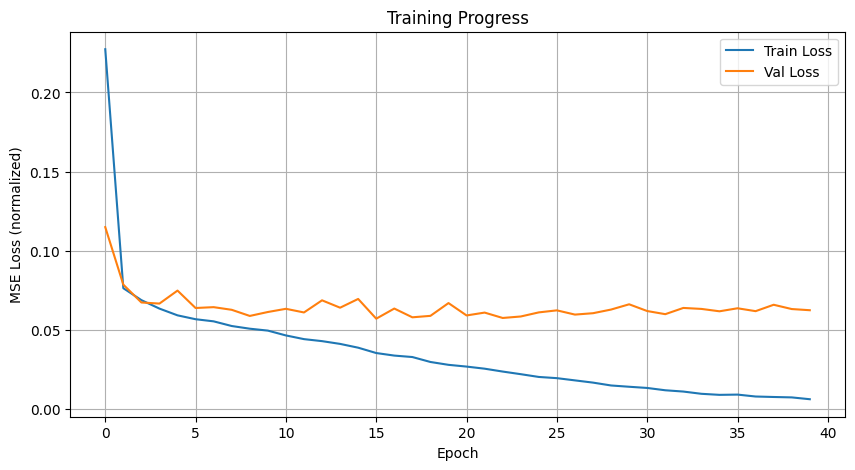


Sample predictions (denormalized):
True: 38.30 | Pred: 50.37
True: -8.85 | Pred: -10.56
True: 132.05 | Pred: 141.81
True: -18.06 | Pred: -12.27
True: 67.93 | Pred: 65.46


In [ ]:
# ============= Some settings =============

hidden_size = 64
num_layers = 4
embedding_size = 64
batch_size = 32
num_epochs = 40
lr = 0.0005
# train the model
def collate_fn(batch):
    """Custom collate function for variable-length peptide sequences"""
    # Extract sequences and convert to tensors if needed
    sequences = [item["pep_seq"] for item in batch]
    rts = torch.tensor([item["rt"] for item in batch], dtype=torch.float32)
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    return {
        "pep_seq": sequences_padded,
        "rt": rts,
        "lengths": lengths
    }

# ============= 1. NORMALIZE YOUR TARGETS =============
# This is CRITICAL for training stability
rt_mean = y_train.values.mean()
rt_std = y_train.values.std()

print(f"RT mean: {rt_mean:.2f}, std: {rt_std:.2f}")

y_train_normalized = (y_train.values.flatten() - rt_mean) / rt_std
y_val_normalized = (y_val.values.flatten() - rt_mean) / rt_std

# ============= 2. FIX MODEL OUTPUT =============
class Rnn(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, embedding_size=None):
        super(Rnn, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.h2o = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 1),
        )
    
    def forward(self, x, lengths):
        x = self.embedding(x)
        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(x_packed)
        final_hidden = hidden[-1]
        output = self.h2o(final_hidden)
        
        return output.squeeze(-1)  #(batch, 1) -> (batch,)

# ============= 3. CREATE DATASETS WITH NORMALIZED DATA =============
train_dataset = PeptideDataset(encoded_pep_seq_train, y_train_normalized)
val_dataset = PeptideDataset(encoded_pep_seq_val, y_val_normalized)
test_dataset = PeptideDataset(encoded_pep_seq_test, y_test.values)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ============= 4. INITIALIZE MODEL =============
vocab_size = len(vocab)

rnn_model = Rnn(vocab_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, embedding_size=embedding_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

# ============= 5. PROPER TRAINING LOOP =============
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ===== TRAINING =====
    rnn_model.train()
    train_loss = 0
    
    for batch in dataloader_train:
        seq = batch["pep_seq"]
        rt = batch["rt"]
        lengths = batch["lengths"]
        
        # Forward pass
        output = rnn_model(seq, lengths)
        loss = criterion(output, rt)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    
    # ===== VALIDATION =====
    rnn_model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in dataloader_val:
            seq = batch["pep_seq"]
            rt = batch["rt"]
            lengths = batch["lengths"]
            
            output = rnn_model(seq, lengths)
            loss = criterion(output, rt)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# ============= 6. PLOT LEARNING CURVES =============
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (normalized)')
plt.legend()
plt.title('Training Progress')
plt.grid(True)
plt.show()


In [56]:
# perform the validation prediction for all val RTs
rnn_model.eval()
rt_preds = []
with torch.no_grad():
    for batch in dataloader_val:

        seq = batch["pep_seq"]
        rt_true = batch["rt"]
        lengths = batch["lengths"]
    
        rt_pred = rnn_model(seq, lengths)
    
        # Denormalize for comparison
        rt_pred_denorm = rt_pred * rt_std + rt_mean
        rt_preds.append(rt_pred_denorm)

Pearon corr:  0.9685322442615031
MAE 7.7163475444923355


/var/folders/8z/k5tph_7d3cd3tq2s362kbfch0000gn/T/ipykernel_8584/192711063.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rt_preds = np.array(torch.cat(rt_preds))


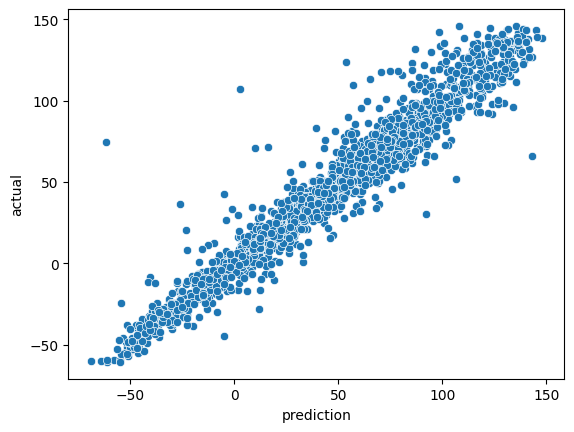

In [57]:
rt_preds = np.array(torch.cat(rt_preds))
y_pred = rt_preds
y_true = y_val.values.flatten()
sns.scatterplot(
    x=y_pred,
    y=y_true
)
plt.xlabel("prediction")
plt.ylabel("actual")
print("Pearon corr: ", np.corrcoef(y_pred, y_true)[0, -1])
def mae(y_pred, y):
    return np.mean(np.abs(y_pred -y))
print(f"MAE {mae(y_pred, y_true)}")

In [37]:
# perform the test prediction for all val RTs
rnn_model.eval()
rt_preds_test = []
with torch.no_grad():
    for batch in dataloader_test:

        seq = batch["pep_seq"]
        rt_true = batch["rt"]
        lengths = batch["lengths"]
    
        rt_pred = rnn_model(seq, lengths)
    
        # Denormalize for comparison
        rt_pred_denorm = rt_pred * rt_std + rt_mean
        rt_preds_test.append(rt_pred_denorm)

In [46]:
rt_pred_tests = np.array(torch.concat(rt_preds_test))
rt_prediction_rnn_embedding = pd.DataFrame(
    data=rt_pred_tests, columns=["RetentionTime"]
)
rt_prediction_rnn_embedding["ID"] = test_data["ID"]

rt_prediction_rnn_embedding.sort_index(axis=1).to_csv("rt_prediction_rnn_embedding.csv", index=False)

/var/folders/8z/k5tph_7d3cd3tq2s362kbfch0000gn/T/ipykernel_8584/641324048.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rt_pred_tests = np.array(torch.concat(rt_preds_test))


In [7]:
torch.arange(0, d_model, 2).float()

tensor([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
         24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
         48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
         72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
         96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
        120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
        144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
        192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
        216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
        240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
        264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
        288., 290., 292., 294., 296., 29

In [ ]:
(-math.log(10000.0) / d_model)

-9.210340371976184

<Axes: >

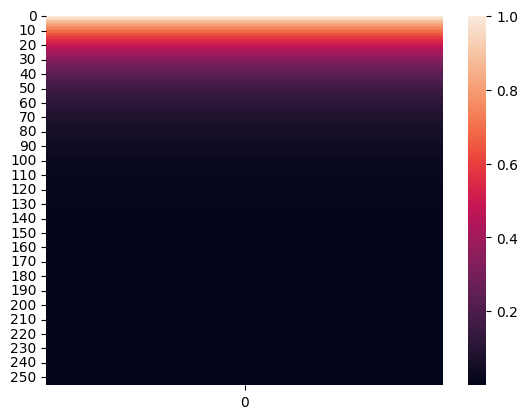

In [6]:
import math
import torch
import seaborn as sns

d_model = 512
div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))

sns.heatmap(div_term.reshape(-1, 1))